In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Burgers' equation

The inviscid Burgers' equation is the simplest nonlinear wave equation, and serves as a great stepping stone toward doing full hydrodynamics.

$$u_t + u u_x = 0$$

This looks like the linear advection equation, except the quantity being advected is the velocity itself.  This means that $u$ is no longer a constant, but can vary in space and time.

Written in conservative form, 

$$\frac{\partial u}{\partial t} + \frac{\partial F(u)}{\partial x} = 0$$

it appears as:

$$u_t + \left [ \frac{1}{2} u^2 \right ]_x = 0$$

so the flux is $F(u) = \frac{1}{2} u^2$.

In the finite volume approach, we integrate over the volume of a cell to get the update:

$$\frac{\partial \langle u \rangle_i}{\partial t} = - \frac{1}{\Delta x} (F_{i+1/2} - F_{i-1/2})$$

To second order accuracy, as we saw previously, $\langle u \rangle_i \approx u_i$, so we'll drop the $\langle \rangle$ here.

Our solution method is essentially the same, aside from the Riemann problem.  We still want to use the idea of upwinding, but now we have a problem&mdash;the nonlinear nature of the Burgers' equation means that information can "pile up" and we lose track of where the flow is coming from.  This gives rise to a nonlinear wave called a shock.

For the linear advection equation, the solution was unchanged along the lines $x - ut = \mbox{constant}$&mdash;we called these the *characteristic curves*.

We can visualize the characteristics as show below:

![advection equation characteristics](advection-characteristics.png)

The top panel shows the initial $a(x, t=0)$, and the bottom shows the characteristic curves in the $x$-$t$ spacetime diagram.  We see that at any $t > 0$, we find the value of $a(x, t)$ by simply tracing backwards along the characteristic curve to the initial conditions.  Since $u$ is constant in the advection equation, the characteristic curves are parallel.

The characteristic curves are the curves on which the solution is constant.
For Burgers' equation, the characteristic curves are given by $dx/dt = u$, but now $u$ varies in the domain.  To see this, look at the change of $u$ in a fluid element (the full, or Lagrangian time derivative):

$$\frac{du}{dt} = \frac{\partial u}{\partial t} + \frac{dx}{dt} \frac{\partial u}{\partial x} =
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$$

We see that $du/dt = 0$ since it just gives us the Burgers equation.  So $u$ is constant along the curves $dx/dt = 0$, but now $u$ varies in the domain.  So if we look at the characteristic curves in the spacetime diagram, we get:

![converging characteristics for the Burgers' equation](burgers-characteristics-shock.png)

Now we see that, for these initial conditions, at some point in the future the characteristics intersect.  This means that there is not a unique curve that we can trace back along to find the value of $u(x,t)$.  The information about where the solution was coming from was lost.  This is the situation of a *shock*.  The correct solution here is to put a discontinuous jump between the left and right states where the characteristics intersect.  The speed of the shock can be found from the Rankine-Hugoniot conditions.

It is also possible to get a *rarefaction* if the characteristics diverge:

![diverging characteristics for the Burgers' equation](burgers-characteristics-rare.png)

## Numerical solution

We'll use the same finite-volume grid class, with one change&mdash;we'll allow for "outflow" boundary conditions.  These simply enforce a zero gradient in the ghost cells, so:

$$u_{\mathrm{lo}-1} = u_{\mathrm{lo}}$$
$$u_{\mathrm{lo}-2} = u_{\mathrm{lo}}$$

and similar at the right boundary.

In [9]:
class FVGrid:

    def __init__(self, nx, ng, bc="outflow",
                 xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered, left and right edges
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx
        self.xl = xmin + (np.arange(nx+2*ng)-ng)*self.dx
        self.xr = xmin + (np.arange(nx+2*ng)-ng+1.0)*self.dx

        # storage for the solution
        self.u = self.scratch_array()
        self.uinit = self.scratch_array()

        self.bc = bc
        
    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self, atmp):
        """ fill all ghostcells """
 
        if self.bc == "periodic":

            # left boundary
            atmp[0:self.ilo] = atmp[self.ihi-self.ng+1:self.ihi+1]

            # right boundary
            atmp[self.ihi+1:] = atmp[self.ilo:self.ilo+self.ng]

        elif self.bc == "outflow":

            # left boundary
            atmp[0:self.ilo] = atmp[self.ilo]

            # right boundary
            atmp[self.ihi+1:] = atmp[self.ihi]

        else:
            sys.exit("invalid BC")

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))
    
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot(self.x, self.uinit, label="initial conditions")
        ax.plot(self.x, self.u)
        ax.legend()
        return fig

The Riemann problem is more complicated.  If there is compression $u_l > u_r$, then we have a shock, and we need to compute the shock speed and then upwind based on that.  For the Burgers' equation, the shock speed is obtained via the Rankine-Hugoniot jump conditions as:

$$S = \frac{f(u_r) - f(u_l)}{u_r - u_l} = \frac{ \frac{1}{2}u_r^2 - \frac{1}{2}u_l^2}{u_r - u_l} = \frac{1}{2} (u_l + u_r)$$

For an interface in our domain:

$$S = \frac{1}{2} (u_{i+1/2,L} + u_{i+1/2,R})$$

Then our Riemann problem is 

$$u_{i+1/2} = \mathcal{R}(u_{i+1/2,L}, u_{i+1/2,R}) = \left \{ \begin{array}{cc}
         u_s & \mbox{if}~ u_{i+1/2,L} > u_{i+1/2,R} \\
         u_r & \mbox{otherwise} \end{array} \right .
$$

where $u_s$ is the shock case:

$$u_s = \left \{ \begin{array}{cc}
     u_{i+1/2,L} & \mbox{if}~ S > 0 \\
     u_{i+1/2,R} & \mbox{if}~ S < 0 \end{array} \right .
$$

and $u_r$ is the rarefaction case:

$$u_r = \left \{ \begin{array}{cc}
     u_{i+1/2,L} & \mbox{if}~ u_{i+1/2,L} > 0 \\
     u_{i+1/2,R} & \mbox{if}~ u_{i+1/2,R} < 0 \\
     0           & \mbox{otherwise} \end{array} \right .
$$



One we have the interface state, $u_{i+1/2}$, we can compute the flux:

$$F_{i+1/2} = \frac{1}{2} u_{i+1/2}^2$$

and then the divergence of the fluxes:

$$-\frac{1}{\Delta x} (F_{i+1/2} - F_{i-1/2}) = -\frac{1}{\Delta x} \left ( \frac{1}{2} u_{i+1/2}^2 - \frac{1}{2} u_{i-1/2}^2 \right )$$

In [5]:
def flux_update(gr, u):
    """compute -div{F} for linear advection"""

    # slope -- we'll do the minmod limiter
    
    # dl = u_i - u_{i-1}
    dl = gr.scratch_array()
    dl[gr.ilo-1:gr.ihi+2] = u[gr.ilo-1:gr.ihi+2] - u[gr.ilo-2:gr.ihi+1]

    # dr = u_{i+1} - u_i
    dr = gr.scratch_array()
    dr[gr.ilo-1:gr.ihi+2] = u[gr.ilo:gr.ihi+3] - u[gr.ilo-1:gr.ihi+2]
    
    d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
    du = np.where(dl*dr > 0.0, d1, 0.0)

    # unlimited
    #du[gr.ilo-1:gr.ihi+2] = 0.5*(u[gr.ilo:gr.ihi+3] - u[gr.ilo-2:gr.ihi+1])

    
    # compute the left and right interface states
    # Note that there are 1 more interfaces than zones

    ul = gr.scratch_array()
    ur = gr.scratch_array()
    
    # u_{i-1/2,R} = u_i - 1/2 du_i
    ur[gr.ilo:gr.ihi+2] = u[gr.ilo:gr.ihi+2] - 0.5 * du[gr.ilo:gr.ihi+2]

    # u_{i-1/2,L} = u_{i-1} + 1/2 du_{i-1}
    ul[gr.ilo:gr.ihi+2] = u[gr.ilo-1:gr.ihi+1] + 0.5 * du[gr.ilo-1:gr.ihi+1]
    
    # now do the Riemann problem
    
    S = 0.5 * (ul + ur)
    ushock = np.where(S > 0.0, ul, ur)
    ushock = np.where(S == 0.0, 0.0, ushock)
    
    # rarefaction solution
    urare = np.where(ur <= 0.0, ur, 0.0)
    urare = np.where(ul >= 0.0, ul, urare)
    
    # if we are compressive, then we are a shock
    us = np.where(ul > ur, ushock, urare)
    
    flux_diff = gr.scratch_array()
    flux_diff[gr.ilo:gr.ihi+1] = (0.5 * us[gr.ilo:gr.ihi+1]**2 -
                                  0.5 * us[gr.ilo+1:gr.ihi+2]**2) / gr.dx

    return flux_diff

Now our main driver&mdash;the main difference here compared to linear advection is that we need to recompute dt each timestep, since $u$ changes in space and time.

In [6]:
def burgers_mol(nx, C, tmax, init_cond=None):

    # create a grid
    g = FVGrid(nx, ng=2)

    # setup initial conditions
    init_cond(g)

    g.uinit[:] = g.u[:]
    
    t = 0.0
    while t < tmax:

        # compute the timestep
        dt = C * g.dx / np.abs(g.u).max()

        if t + dt > tmax:
            dt = tmax - t

        # second-order RK integration
        g.fill_BCs(g.u)
        k1 = flux_update(g, g.u)

        utmp = g.scratch_array()
        utmp[:] = g.u[:] + 0.5 * dt * k1[:]

        g.fill_BCs(utmp)
        k2 = flux_update(g, utmp)

        g.u[:] += dt * k2[:]

        t += dt

    return g

Let's test it out with a sine-like initial conditions.  Based on the characteristics shown above, this should result in a shock.

In [7]:
def sine(g):
    g.u[:] = 1.0

    index = np.logical_and(g.x >= 0.333,
                           g.x <= 0.666)
    g.u[index] += 0.5*np.sin(2.0*np.pi*(g.x[index]-0.333)/0.333)

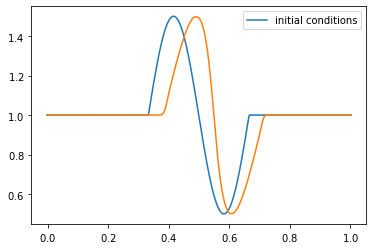

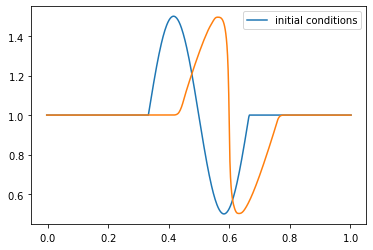

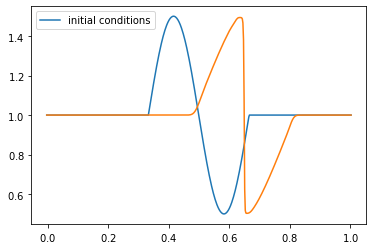

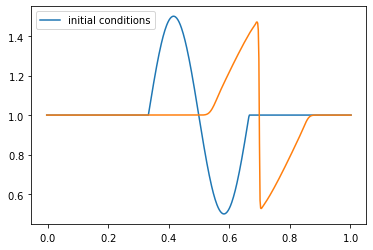

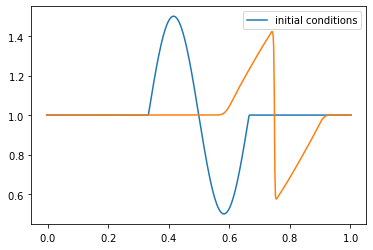

In [10]:
nx = 512
C = 0.5
tmax = 0.25

for tmax in [0.05, 0.10, 0.15, 0.20, 0.25]:
    g = burgers_mol(nx, C, tmax, init_cond=sine)
    fig = g.plot()

Keep in mind that although our method ideally converges as second order in space and time, the slope limiter we use kicks in near discontinuities and reduces the converges locally to first order there.

<div class="alert alert-block alert-info">

**Exercise:**
    
Implement initial conditions that will give rise to a rarefaction and evolve Burgers' equation to see the evolution.
    
</div>

In [11]:
def rare(g):
    g.u[:] = 1.0
    g.u[g.x > 0.5] = 2.0

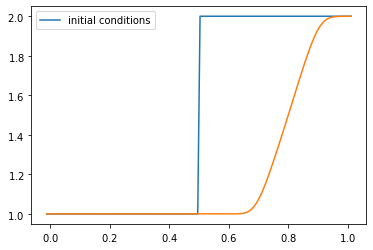

In [13]:
nx = 128
C = 0.5
tmax = 0.2

g = burgers_mol(nx, C, tmax, init_cond=rare)
fig = g.plot()

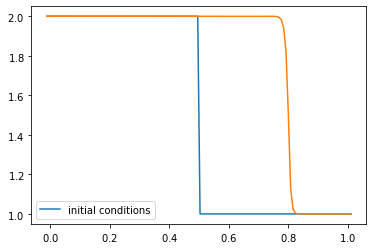

In [14]:
def shock(g):
    g.u[:] = 2.0
    g.u[g.x > 0.5] = 1.0
    
g = burgers_mol(nx, C, tmax, init_cond=shock)
fig = g.plot()

We see that at the end, the shock is at a position of 0.8 and that it started at 0.5.  We can just compute the shock speed as $(x_\mathrm{final} - x_\mathrm{initial}) / \Delta t$

In [15]:
(0.8 - 0.5)/tmax

1.5000000000000002

This is the expected result from the jump conditions.  Because we solve the Riemann problem, which knows about the jump conditions, we get the shock speed correct.  These methods are therefore sometimes called *shock-capturing methods*.